In [2]:
import numpy as np
from netCDF4 import Dataset,Variable
import glob
import pandas as pd
import os 
from itertools import product 
from datetime import datetime

import nclcmaps
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator,MultipleLocator, AutoMinorLocator
import matplotlib.dates as mdates
from matplotlib.colors import BoundaryNorm,from_levels_and_colors,ListedColormap,Normalize,LinearSegmentedColormap

from wrf import (getvar, CoordPair,to_np, xy, interpline,vertcross,interp2dxy,Constants,get_cartopy, latlon_coords, extract_global_attrs)
#import pyart


def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
     new_cmap = LinearSegmentedColormap.from_list(
           'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
            cmap(np.linspace(minval, maxval, n)))
     return new_cmap  
#find the index of nearest value in the array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
# example: find_nearest(height[:,1,1], value=3000)
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#load IOP7 flight track
UWKA_dir='/glade/u/home/sisichen/work_dir/IPC_SNOWIE/WRF_SNOWIE/flight_track_UWKA/'
UWKA_path=UWKA_dir+'IOP7_UWKA'
IOP7_UWKA_data=pd.read_csv(UWKA_path,index_col=False, delimiter=',',header = None, names=\
                ['Lon','Lat','Alt'])
UWKA_lon=IOP7_UWKA_data.Lon
UWKA_lat=IOP7_UWKA_data.Lat
UWKA_Alt=IOP7_UWKA_data.Alt
#load target area of Payette River Basin
PRB='PayetteTarget.txt'
PRB_path=UWKA_dir+PRB
PRB_data=pd.read_csv(PRB_path,index_col=False, header = None, sep=' ',names=\
                     ['Lon','Lat'])

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#read radar simulator file
filedir='/glade/u/home/sisichen/scratch/CRSIM_RUN/IOP7_20m_LES/'
crsimout_filelist=[os.path.basename(x) for x in sorted(glob.glob(filedir+'output/crsimout_*0'), 
                                                     key=os.path.basename)]
wrfout_filelist20m=[os.path.basename(x) for x in sorted(glob.glob(filedir+'wrfout_*'), 
                                                     key=os.path.basename)]
starttime=datetime(2017, 1, 21, 22, 50)
endtime  =datetime(2017, 1, 22, 3,  5)

### Define color bar ###
vmin = -35
vmax = 20
#color = pyart.graph.cm.LangRainbow12
cmap = nclcmaps.cmap('BlAqGrYeOrReVi200')
cmap = truncate_colormap(cmap, 0.01, 1)
colorlist  = [cmap(i) for i in range(cmap.N)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', colorlist, cmap.N)
bounds = np.arange(vmin,vmax+1,1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
levels = MaxNLocator(nbins=120).tick_values(vmin, vmax)
#levels_qcloud = MaxNLocator(nbins=40).tick_values(vmin, vmax)
# norm_qcloud = BoundaryNorm(levels_qcloud, ncolors=cmap_qcloud.N, clip=False)

#color = pyart.graph.cm.LangRainbow12
#dbz perturb
cmap0=plt.cm.coolwarm
levels0 = MaxNLocator(nbins=20).tick_values(-10,10)
norm0= BoundaryNorm(levels0, ncolors=cmap0.N, clip=False)

#vertical velocity
cmap_wa = plt.cm.coolwarm#Blues#truncate_colormap(orig_map, 0.2, 1.0)
levels_wa = MaxNLocator(nbins=20).tick_values(-2,2)
norm_wa = BoundaryNorm(levels_wa, ncolors=cmap_wa.N, clip=False)

#snow+graup
cmap_iwc=plt.cm.winter
levels_iwc = MaxNLocator(nbins=20).tick_values(0.05, 1)
norm_iwc = BoundaryNorm(levels_iwc, ncolors=cmap_iwc.N, clip=False)
#lwc
cmap_lwc = plt.cm.summer #truncate_colormap(orig_map, 0.2, 1.0)
levels_lwc = MaxNLocator(nbins=10).tick_values(0.05, .5)
norm_lwc = BoundaryNorm(levels_lwc, ncolors=cmap_lwc.N, clip=False)
#ice
cmap_ice=plt.cm.spring
levels_ice = MaxNLocator(nbins=20).tick_values(0.00005, .001)
norm_ice = BoundaryNorm(levels_ice, ncolors=cmap_ice.N, clip=False)
print('done setting up the colormap and start end times')

done setting up the colormap and start end times


/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
#get the reflectivity disturbance and only plot dbz>1 region
ntotal=0
levs = np.arange(1500,5000,50)
plt.rc('font', size=25)
for wrfout_file in wrfout_filelist20m:
    wrf_time=datetime.strptime(wrfout_file[11:27], "%Y-%m-%d_%H:%M")
    if wrf_time >= starttime and wrf_time <= endtime:
        wrf_file=filedir+wrfout_file
        ntotal=ntotal+1
        Times=wrfout_file[22:30]
        print('read Time = '+wrfout_file[11:27])
        crsim_file=filedir+'output/crsimout_'+Times
        if os.path.exists(crsim_file):
            ncfile = Dataset(wrf_file,mode='r')
            fh=Dataset(crsim_file, "r", format="NETCDF4")
            xlat=fh.variables['xlat'][:]
            xlong=fh.variables['xlong'][:]
            height=fh.variables['height'][:]# in m.
            Zhh=fh.variables['Zhh'][:]#"Reflectivity at hh polarization" in dBZ
            Ah = fh.variables['Ah'][:]#"Specific horizontal attenuation" in dBZ/km
            height_of_radar=fh.variables['rad_zc'][:].data
            if ntotal == 1:
                # Get the lat/lon points
                ter = getvar(ncfile, "ter")
                lats, lons = latlon_coords(ter)
                ## NNW - SSE
                # cross_start = CoordPair(lat=lats[912,568], lon=lons[912,568] )
                # cross_end =   CoordPair(lat=lats[500,840], lon= lons[500,840] )
                ## WSW-NEN
                cross_start = CoordPair(lat=lats[322,6], lon=lons[322,6] )
                cross_end =   CoordPair(lat=lats[892,845], lon= lons[892,845] )
                ter_line = interpline(ter, wrfin=ncfile, start_point=cross_start,
                                  end_point=cross_end)  
                start_point = CoordPair(x = 0, y = 0)
                end_point = CoordPair(x = -1, y = -1)
                # xs = np.arange(0, ter_line.shape[-1], 1)/50
            ht = getvar(ncfile, "z")

            Zhh_cross=vertcross(np.asarray(Zhh), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)
            invalid = np.logical_or(Zhh_cross>50,Zhh_cross<-80)
            Zhh_cross[invalid] = np.nan
            lonplot = np.linspace(xlong[0,0],xlong[-1,-1],Zhh_cross.shape[1])
            latplot = np.linspace(xlat[0,0],xlat[-1,-1],Zhh_cross.shape[1])
            x_ticks = np.arange(lonplot.shape[0])
            Ah_cross=vertcross(np.asarray(Ah), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)
            invalid = np.logical_or(Ah_cross<0,Ah_cross>2000)
            Ah_cross[invalid]=np.nan

            height_cross=vertcross(np.asarray(height), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)

            #calculate the observable radar signal (Zhh_obs) 
            # methods and formula of calculation refer to M.Oue et al. 2020 (GMD) 
            # Oue, M., Tatarevic, A., Kollias, P., Wang, D., Yu, K., and Vogelmann, A. M.: 
            # The Cloud-resolving model Radar SIMulator (CR-SIM) Version 3.3: description and applications of a virtual observatory, 
            # Geosci. Model Dev., 13, 1975–1998, https://doi.org/10.5194/gmd-13-1975-2020, 2020.

            #find radar height
            radar_k=np.zeros(height_cross.shape[1])
            for i in range(height_cross.shape[1]): #find k index of radar along the track
                radar_k[i]=find_nearest(height_cross[:,i], value=height_of_radar)#find the k index of the radar location.

            # #first get the total hydrometeor attenuation A_tot
            Zhh_cross_obs=Zhh_cross.copy()
            for i,k in product(range(len(radar_k)),range(Zhh_cross.shape[0])): #i is the nx, k is nz
                if k<radar_k[i]: #target is below the radar
                    #to get the radar signal below the aircraft
                    #for k_botup in range(k,int(radar_k[i])):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
                elif k>radar_k[i]:#target above the radar
                    #for k_botup in range(int(radar_k[i])+1,k+1):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000

            fig = plt.figure(figsize=(40,8))
            ax_cross = plt.axes()
            #get the observed dbz
            Zhh_obs_final=Zhh_cross_obs.copy()
            Zhh_obs_final[np.where(Zhh_obs_final<-35)]=np.nan
            #Zhh_obs_final[np.isnan(Zhh_cross_obs)]=-50
            #get dbz perturbation
            #first convert back to linear scale before subtracting to mean
            dBZ2Z=10**(Zhh_obs_final/10)
            dBZ2Z_hrz_mean=np.ma.mean(dBZ2Z, axis=1) #average at each level
            # dBZ2Z_pert=[dBZ2Z[:,i]-dBZ2Z_hrz_mean for i in range(Zhh_obs_final.shape[1])]
            # dBZ_pert=10*np.log10(dBZ2Z_pert)
            dBZ_hrz_mean=10*np.log10(dBZ2Z_hrz_mean) 
            dBZ_pert=[Zhh_obs_final[:,i]-dBZ_hrz_mean for i in range(Zhh_obs_final.shape[1])]
            #rotate and flip the array to go with Zhh_obs_final
            dBZ_pert_final=np.rot90(np.array(dBZ_pert),k=3,axes=(0,1))
            dBZ_pert_final=np.fliplr(dBZ_pert_final)
            dBZ_pert_final=np.ma.array(dBZ_pert_final,mask=np.isnan(Zhh_obs_final))
            dBZ_pert_final_pos=dBZ_pert_final.copy()
            dBZ_pert_final_pos[np.where(dBZ_pert_final<1)]=np.nan
            xs=x_ticks/50
            levels1= MaxNLocator(nbins=1).tick_values(1, 2)
            dbz_contour=ax_cross.contourf(xs,levs/1000,dBZ_pert_final,levels=levels0, norm=norm0, cmap = cmap0,extend='both')
            dbz_pos_contour=ax_cross.contour(xs,levs/1000,dBZ_pert_final_pos,levels=levels1, colors='k')
            
            ax_cross.set_xlabel('distance(km)')
            ax_cross.set_ylabel('Altitude (km MSL)')
            cb = fig.add_axes([.92,.15,.01,.6])
            # Add colorbar, make sure to specify tick locations to match desired ticklabels
            cbar = fig.colorbar(dbz_contour,orientation='vertical', label='dBZ',cax=cb, ticks=np.arange(-20,20,4))
            ax_cross.set_ylim(1,5)
            ax_cross.xaxis.set_major_locator(MultipleLocator(1))
            ax_cross.xaxis.set_major_formatter('{x:.0f}')
            ax_cross.xaxis.set_minor_locator(MultipleLocator(.1))
            # Fill in the mountain area
            ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line/1000),
                                           facecolor="black",edgecolor='black',zorder=10)
            ax_cross.set_title('T = '+wrfout_file[11:27]+' UTC')
            fig.savefig("20m_uwka_MR_"+wrfout_file[11:27]+".png", bbox_inches = "tight")
            plt.close('all')
print('finished all plots')  

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


read Time = 2017-01-21_22:50


<ipython-input-3-def01e8cbe2b>:68: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
<ipython-input-3-def01e8cbe2b>:71: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000
<ipython-input-3-def01e8cbe2b>:85: RuntimeWarning: divide by zero encountered in log10
  dBZ_hrz_mean=10*np.log10(dBZ2Z_hrz_mean)


read Time = 2017-01-21_22:52
read Time = 2017-01-21_22:55
read Time = 2017-01-21_22:57
read Time = 2017-01-21_23:00
read Time = 2017-01-21_23:02
read Time = 2017-01-21_23:05
read Time = 2017-01-21_23:07
read Time = 2017-01-21_23:10
read Time = 2017-01-21_23:12
read Time = 2017-01-21_23:15
read Time = 2017-01-21_23:17
read Time = 2017-01-21_23:20
read Time = 2017-01-21_23:22
read Time = 2017-01-21_23:25
read Time = 2017-01-21_23:27
read Time = 2017-01-21_23:30
read Time = 2017-01-21_23:32
read Time = 2017-01-21_23:35
read Time = 2017-01-21_23:37
read Time = 2017-01-21_23:40
read Time = 2017-01-21_23:42
read Time = 2017-01-21_23:45
read Time = 2017-01-21_23:47
read Time = 2017-01-21_23:50
read Time = 2017-01-21_23:52
read Time = 2017-01-21_23:55
read Time = 2017-01-21_23:57
read Time = 2017-01-22_00:00
read Time = 2017-01-22_00:02
read Time = 2017-01-22_00:05
read Time = 2017-01-22_00:07
read Time = 2017-01-22_00:10
read Time = 2017-01-22_00:12
read Time = 2017-01-22_00:15
read Time = 20

In [5]:
#get the dBZ profiles with mixing ratio
ntotal=0
levs = np.arange(1500,5000,50)
plt.rc('font', size=25)
for wrfout_file in wrfout_filelist20m:
    wrf_time=datetime.strptime(wrfout_file[11:27], "%Y-%m-%d_%H:%M")
    if wrf_time >= starttime and wrf_time <= endtime:
        wrf_file=filedir+wrfout_file
        ntotal=ntotal+1
        Times=wrfout_file[22:30]
        print('read Time = '+wrfout_file[11:27])
        crsim_file=filedir+'output/crsimout_'+Times
        if os.path.exists(crsim_file):
            ncfile = Dataset(wrf_file,mode='r')
            fh=Dataset(crsim_file, "r", format="NETCDF4")
            xlat=fh.variables['xlat'][:]
            xlong=fh.variables['xlong'][:]
            height=fh.variables['height'][:]# in m.
            Zhh=fh.variables['Zhh'][:]#"Reflectivity at hh polarization" in dBZ
            Ah = fh.variables['Ah'][:]#"Specific horizontal attenuation" in dBZ/km
            height_of_radar=fh.variables['rad_zc'][:].data
            if ntotal == 1:
                # Get the lat/lon points
                ter = getvar(ncfile, "ter")
                lats, lons = latlon_coords(ter)
                ## NNW - SSE
                # cross_start = CoordPair(lat=lats[912,568], lon=lons[912,568] )
                # cross_end =   CoordPair(lat=lats[500,840], lon= lons[500,840] )
                ## WSW-NEN
                cross_start = CoordPair(lat=lats[322,6], lon=lons[322,6] )
                cross_end =   CoordPair(lat=lats[892,845], lon= lons[892,845] )
                ter_line = interpline(ter, wrfin=ncfile, start_point=cross_start,
                                  end_point=cross_end)  
                start_point = CoordPair(x = 0, y = 0)
                end_point = CoordPair(x = -1, y = -1)
                # xs = np.arange(0, ter_line.shape[-1], 1)/50
            ht = getvar(ncfile, "z")
            qcloud = getvar(ncfile, "QCLOUD")
            qrain = getvar(ncfile, "QRAIN")
            qlwc = qcloud+qrain #lwc
            qice = getvar(ncfile, "QICE")
            qsnow = getvar(ncfile, "QSNOW")
            qgraup = getvar(ncfile, "QGRAUP")
            qiwc = qsnow+qgraup #iwc
            
            qlwc_cross = vertcross(qlwc, ht, wrfin=ncfile, 
                        start_point=cross_start,
                        end_point=cross_end,
                        latlon=True, meta=True)

            qiwc_cross = vertcross(qiwc, ht, wrfin=ncfile, 
                                start_point=cross_start,
                                end_point=cross_end,
                                latlon=True, meta=True)

            qice_cross   = vertcross(qice, ht, wrfin=ncfile,
                                start_point=cross_start,
                                end_point=cross_end,
                                latlon=True, meta=True)
            ys = to_np(qlwc_cross.coords["vertical"])

            Zhh_cross=vertcross(np.asarray(Zhh), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)
            invalid = np.logical_or(Zhh_cross>50,Zhh_cross<-80)
            Zhh_cross[invalid] = np.nan
            lonplot = np.linspace(xlong[0,0],xlong[-1,-1],Zhh_cross.shape[1])
            latplot = np.linspace(xlat[0,0],xlat[-1,-1],Zhh_cross.shape[1])
            x_ticks = np.arange(lonplot.shape[0])
            Ah_cross=vertcross(np.asarray(Ah), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)
            invalid = np.logical_or(Ah_cross<0,Ah_cross>2000)
            Ah_cross[invalid]=np.nan

            height_cross=vertcross(np.asarray(height), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)

            #calculate the observable radar signal (Zhh_obs) 
            # methods and formula of calculation refer to M.Oue et al. 2020 (GMD) 
            # Oue, M., Tatarevic, A., Kollias, P., Wang, D., Yu, K., and Vogelmann, A. M.: 
            # The Cloud-resolving model Radar SIMulator (CR-SIM) Version 3.3: description and applications of a virtual observatory, 
            # Geosci. Model Dev., 13, 1975–1998, https://doi.org/10.5194/gmd-13-1975-2020, 2020.

            #find radar height
            radar_k=np.zeros(height_cross.shape[1])
            for i in range(height_cross.shape[1]): #find k index of radar along the track
                radar_k[i]=find_nearest(height_cross[:,i], value=height_of_radar)#find the k index of the radar location.

            # #first get the total hydrometeor attenuation A_tot
            Zhh_cross_obs=Zhh_cross.copy()
            for i,k in product(range(len(radar_k)),range(Zhh_cross.shape[0])): #i is the nx, k is nz
                if k<radar_k[i]: #target is below the radar
                    #to get the radar signal below the aircraft
                    #for k_botup in range(k,int(radar_k[i])):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
                elif k>radar_k[i]:#target above the radar
                    #for k_botup in range(int(radar_k[i])+1,k+1):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000

            fig = plt.figure(figsize=(40,8))
            ax_cross = plt.axes()
            Zhh_obs_final=Zhh_cross_obs.copy()
            Zhh_obs_final[np.isnan(Zhh_cross_obs)]=-50
            xs=x_ticks/50
            dbz_contour=ax_cross.contourf(xs,levs/1000,Zhh_obs_final, levels=levels, norm=norm, cmap = cmap)
            ax_cross.set_xlabel('distance(km)')
            ax_cross.set_ylabel('Altitude (km MSL)')
            cb = fig.add_axes([.92,.15,.01,.6])
            # Add colorbar, make sure to specify tick locations to match desired ticklabels
            cbar = fig.colorbar(dbz_contour,orientation='vertical', label='dBZ',cax=cb, ticks=np.arange(-40,21,5))
            ax_cross.set_ylim(1,5)
            qice_contour=ax_cross.contour(xs, ys/1000, qice_cross*1e3,
                               levels=levels_ice,
                               cmap=cmap_ice,
                               norm = norm_ice,
                               extend="max")
            qlwc_contour=ax_cross.contour(xs, ys/1000, qlwc_cross*1e3,
                                           levels=levels_lwc,
                                           cmap=cmap_lwc,
                                           norm = norm_lwc,
                                           extend="max")
            qiwc_contour=ax_cross.contour(xs, ys/1000, qiwc_cross*1e3,
                                           levels=levels_iwc,
                                           cmap=cmap_iwc,
                                           norm = norm_iwc,
                                           extend="max")
            # ax_cross.set_xticks(np.arange(0,21,1))
            # ax_cross.set_yticks(np.arange(0,6,1))
            ax_cross.xaxis.set_major_locator(MultipleLocator(1))
            ax_cross.xaxis.set_major_formatter('{x:.0f}')
            ax_cross.xaxis.set_minor_locator(MultipleLocator(.1))
            # Fill in the mountain area
            ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line/1000),
                                           facecolor="black",edgecolor='black',zorder=10)
            ax_cross.set_title('T = '+wrfout_file[11:27]+' UTC')
            fig.savefig("20m_uwka_MR_dbz_"+wrfout_file[11:27]+".png", bbox_inches = "tight")
            plt.close('all')
print('finished all plots')  

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


read Time = 2017-01-21_22:50


<ipython-input-5-d05f0101e4be>:91: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
<ipython-input-5-d05f0101e4be>:94: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000
<ipython-input-5-d05f0101e4be>:118: UserWarning: No contour levels were found within the data range.
  qiwc_contour=ax_cross.contour(xs, ys/1000, qiwc_cross*1e3,


read Time = 2017-01-21_22:52


<ipython-input-5-d05f0101e4be>:91: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
<ipython-input-5-d05f0101e4be>:94: RuntimeWarning: Mean of empty slice
  Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000
<ipython-input-5-d05f0101e4be>:118: UserWarning: No contour levels were found within the data range.
  qiwc_contour=ax_cross.contour(xs, ys/1000, qiwc_cross*1e3,


read Time = 2017-01-21_22:55


KeyboardInterrupt: 

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


read Time = 2017-01-22_01:35


<ipython-input-25-ce5e328aa8b2>:113: RuntimeWarning: divide by zero encountered in log10
  dBZ_hrz_mean=10*np.log10(dBZ2Z_hrz_mean)


read Time = 2017-01-22_01:37
read Time = 2017-01-22_01:40
read Time = 2017-01-22_01:42
read Time = 2017-01-22_01:45
read Time = 2017-01-22_01:47
read Time = 2017-01-22_01:50
read Time = 2017-01-22_01:52
read Time = 2017-01-22_01:55
read Time = 2017-01-22_01:57
read Time = 2017-01-22_02:00
read Time = 2017-01-22_02:02
read Time = 2017-01-22_02:05
finished all plots


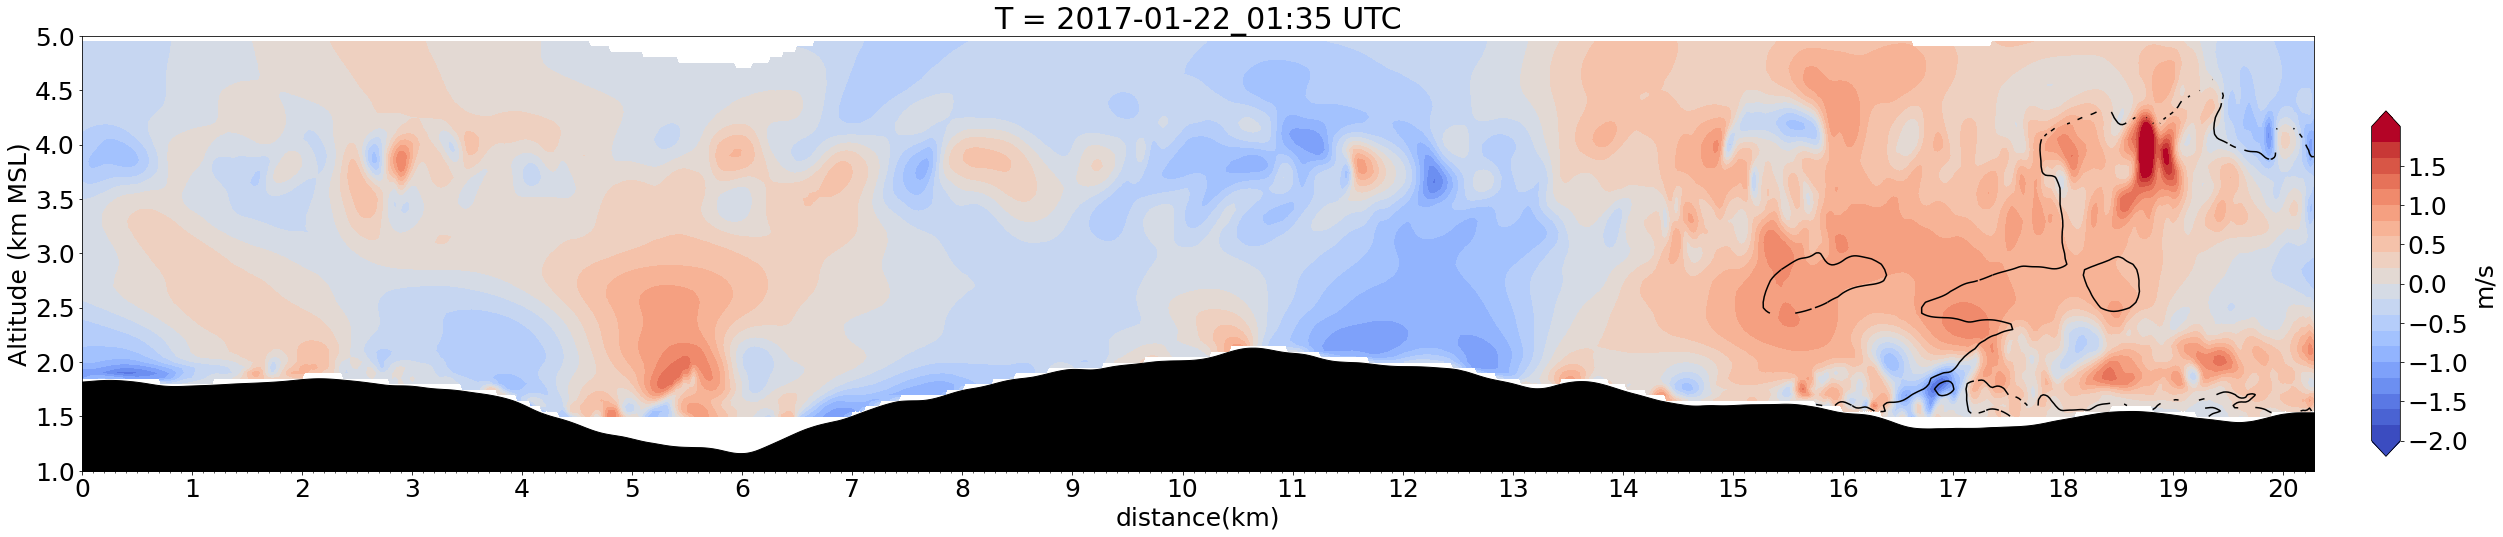

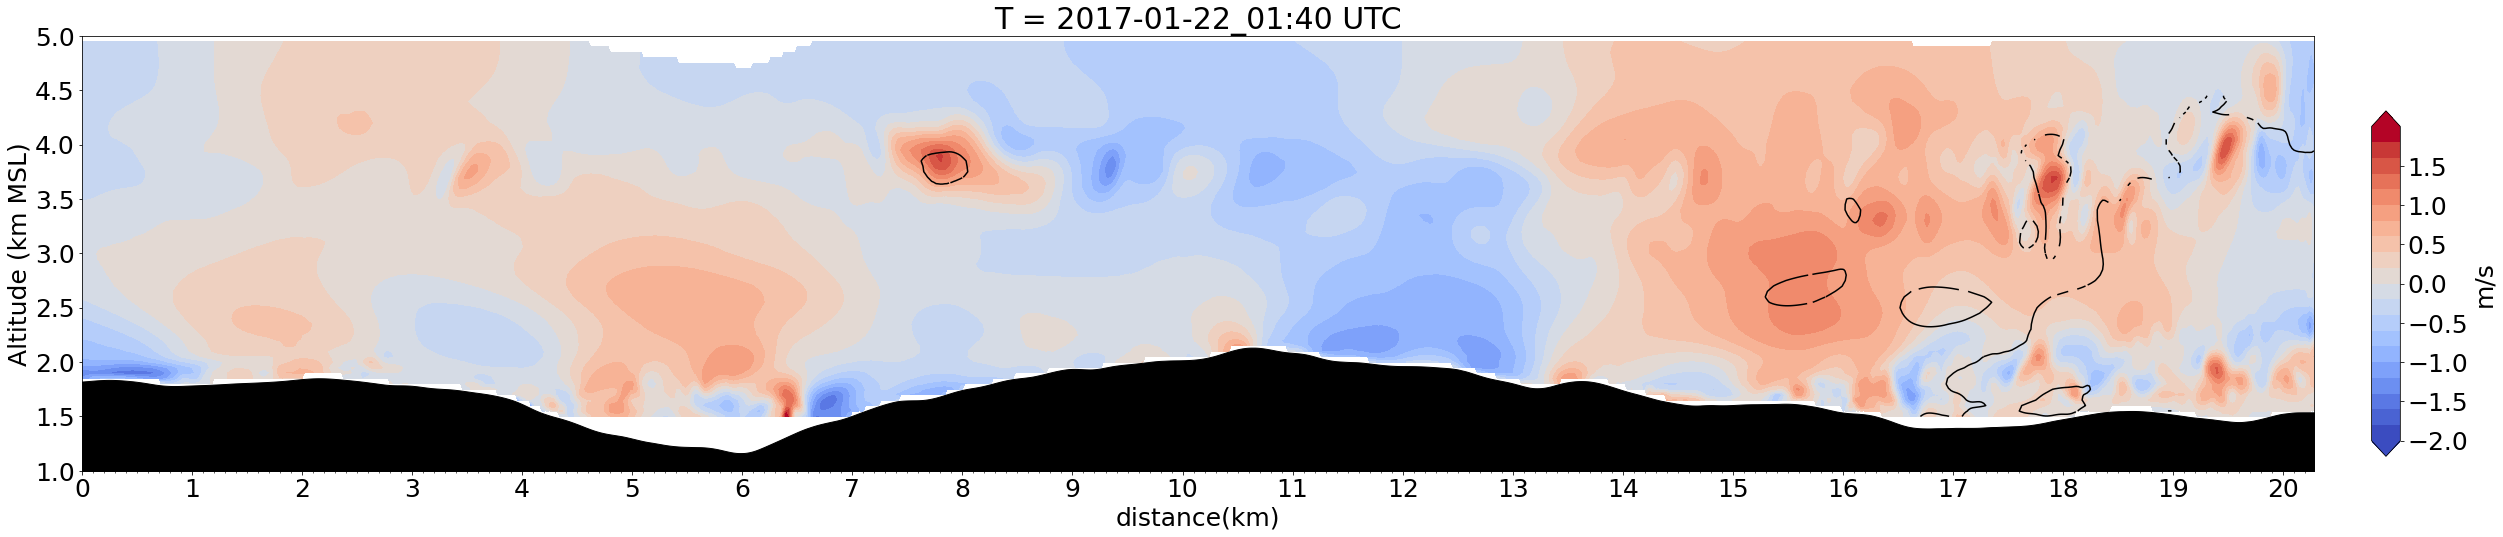

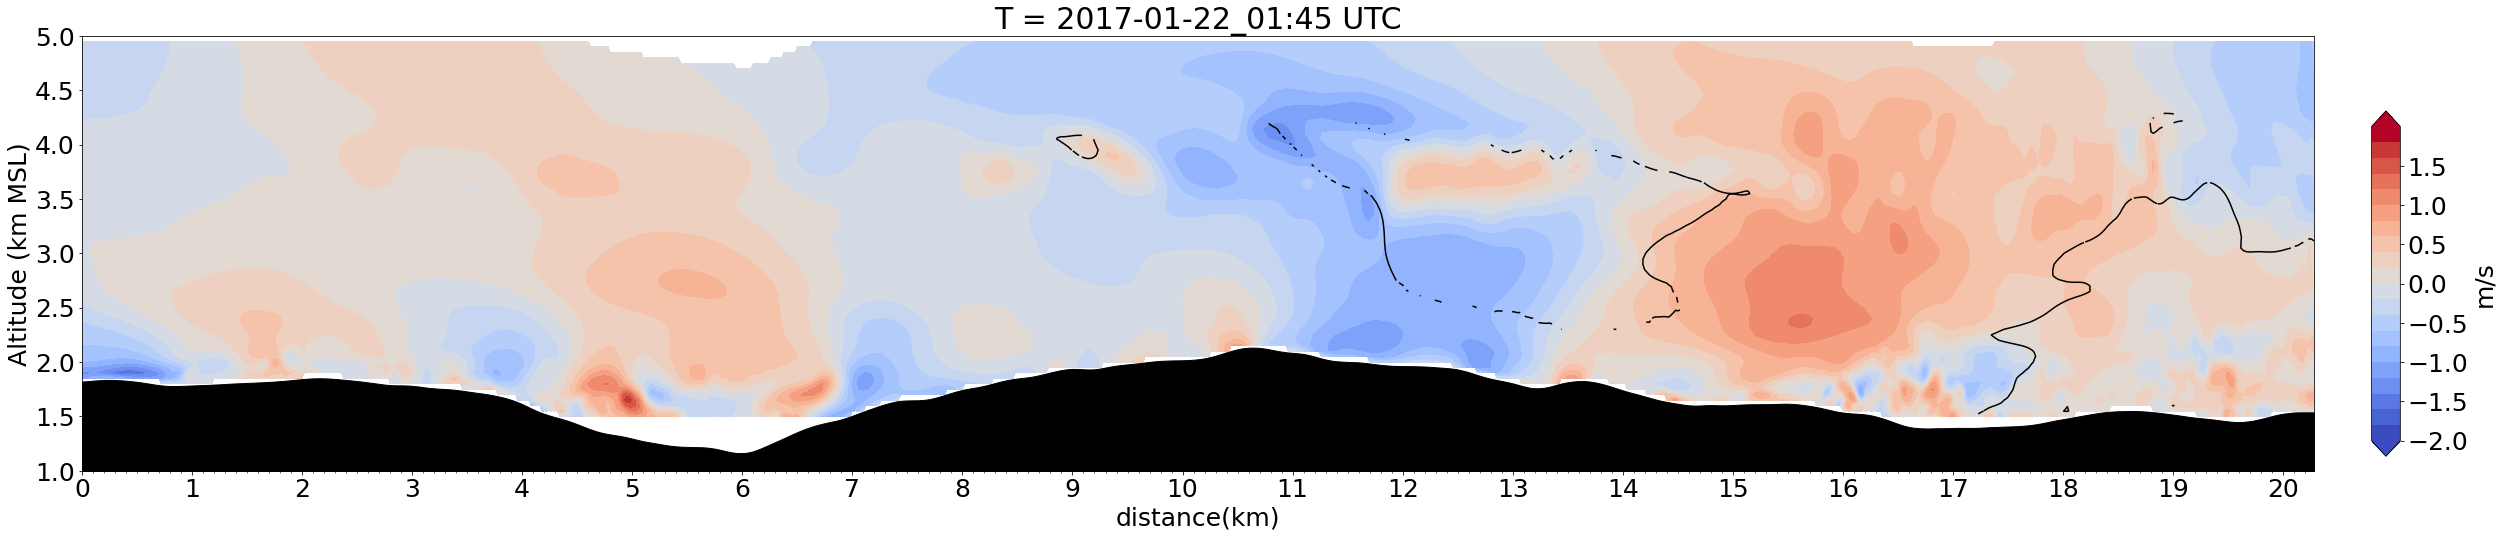

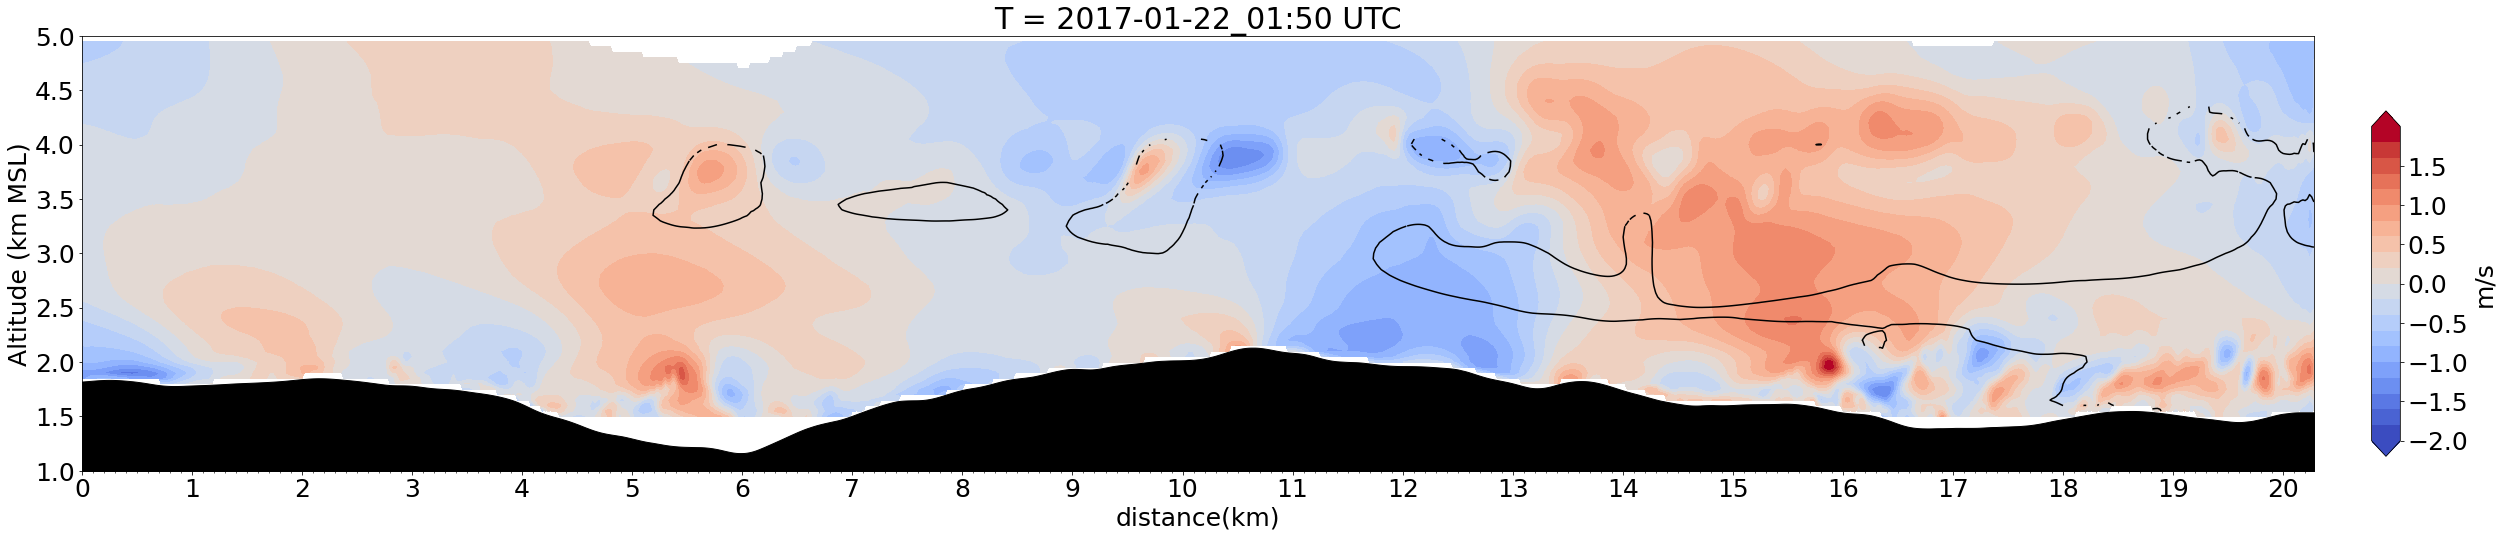

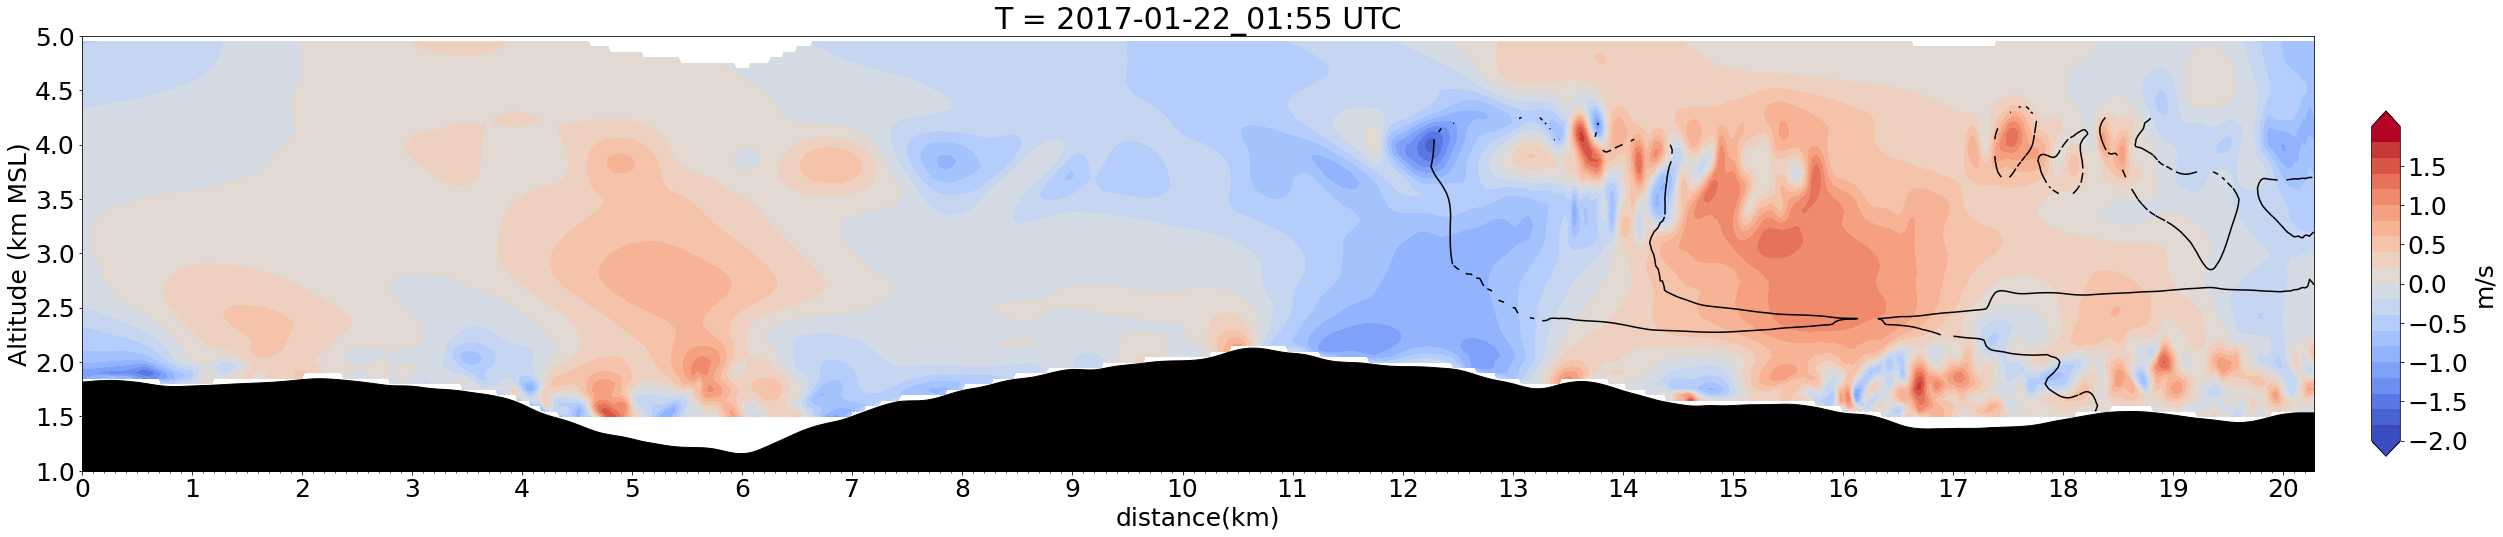

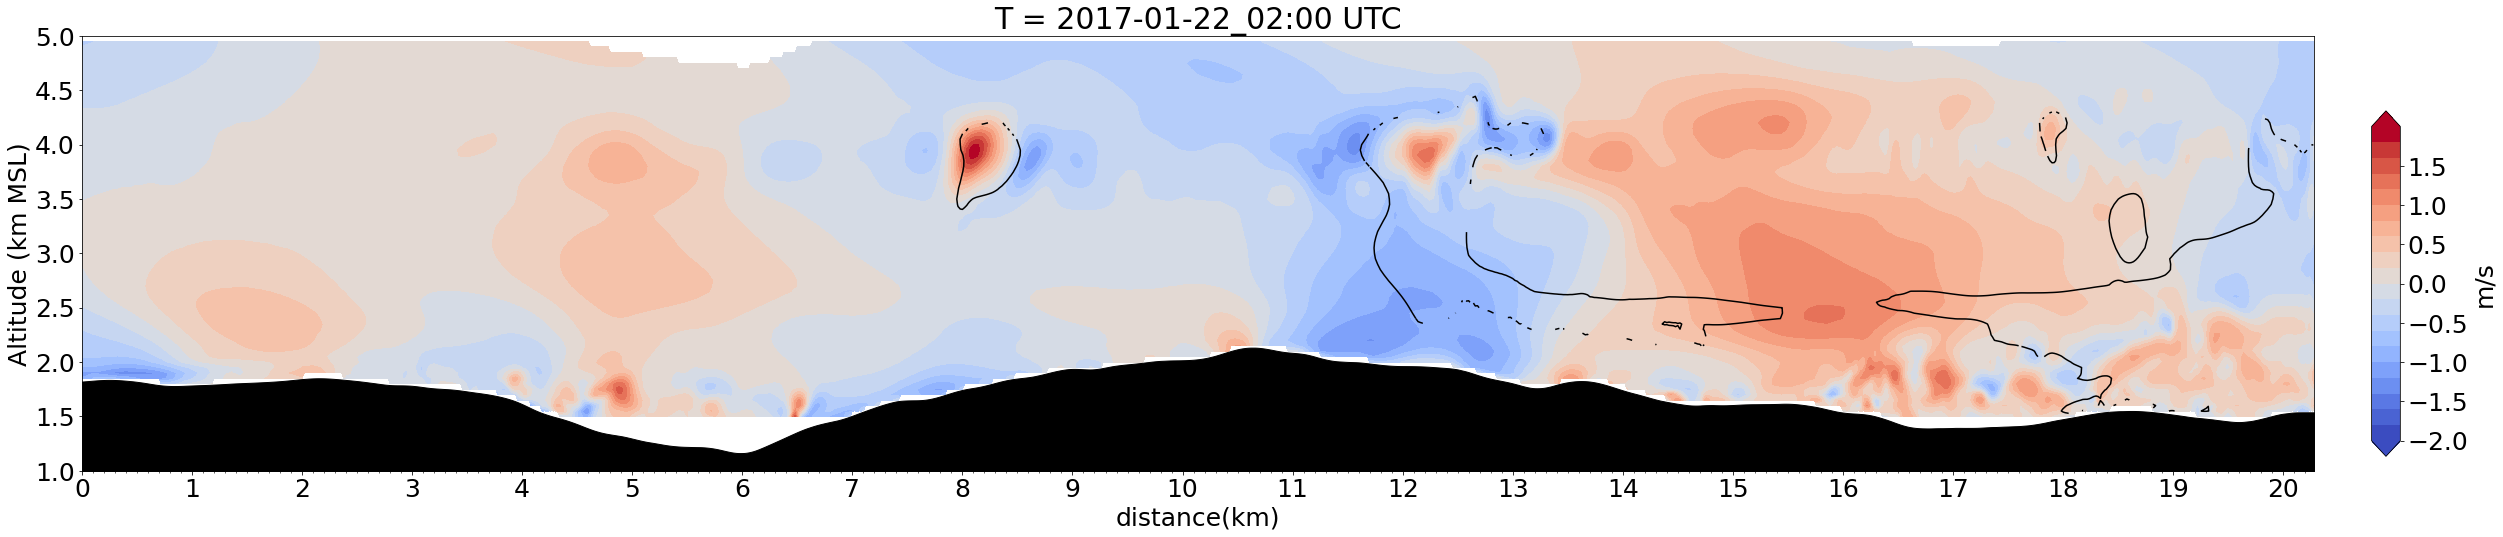

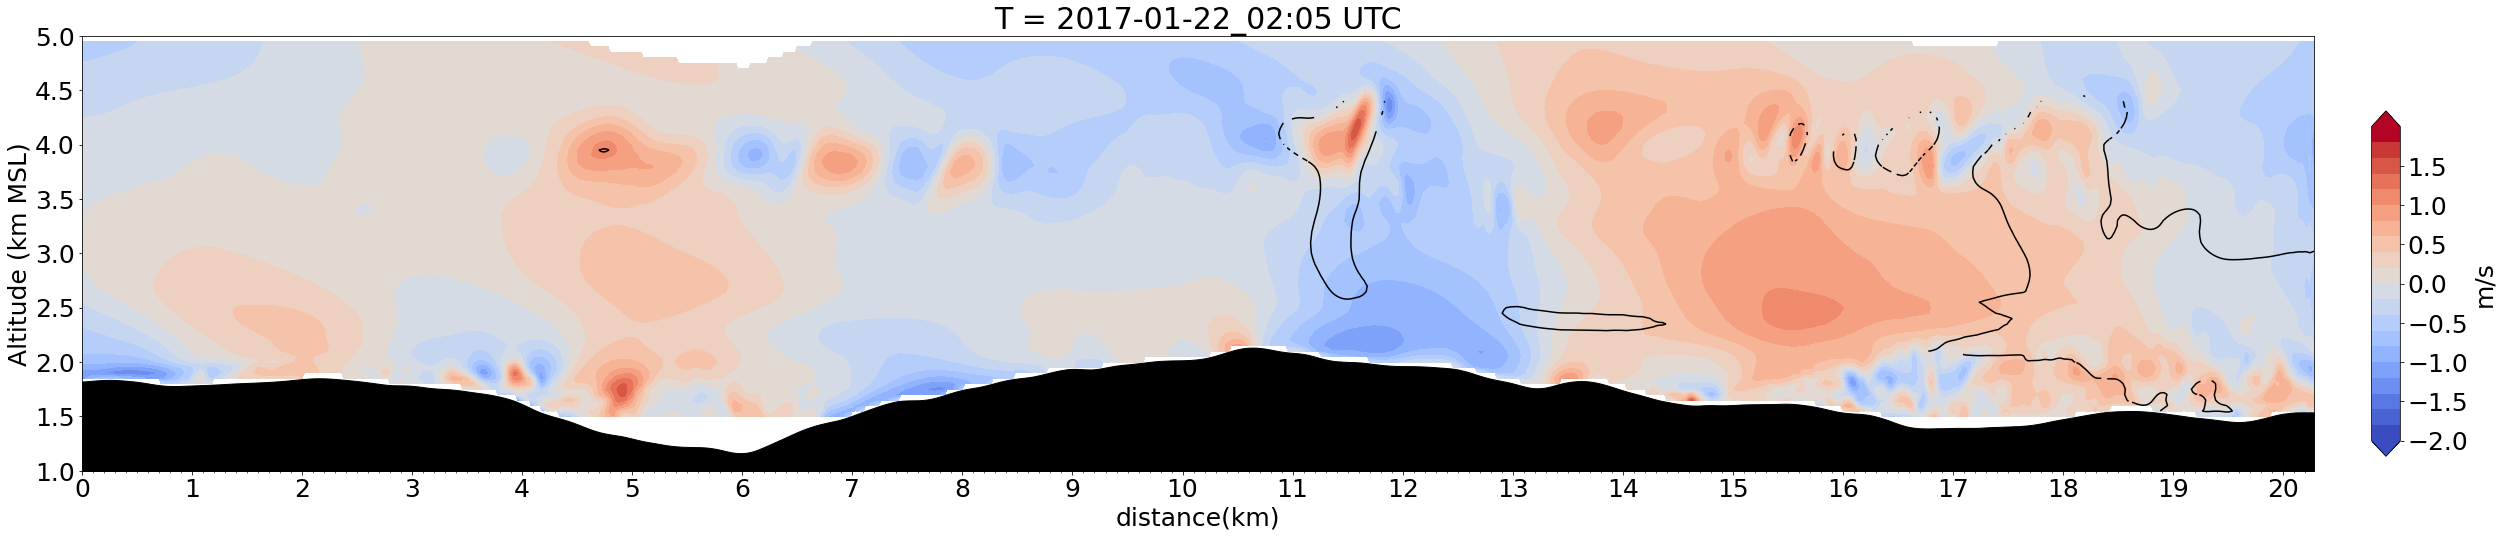

In [25]:
#get the vertical motion and only plot dbz>1 region
ntotal=0
levs = np.arange(1500,5000,50)
plt.rc('font', size=25)
for wrfout_file in wrfout_filelist20m:
    wrf_time=datetime.strptime(wrfout_file[11:27], "%Y-%m-%d_%H:%M")
    if wrf_time >= starttime and wrf_time <= endtime:
        wrf_file=filedir+wrfout_file
        ntotal=ntotal+1
        Times=wrfout_file[22:30]
        print('read Time = '+wrfout_file[11:27])
        crsim_file=filedir+'output/crsimout_'+Times
        if os.path.exists(crsim_file):
            ncfile = Dataset(wrf_file,mode='r')
            fh=Dataset(crsim_file, "r", format="NETCDF4")
            xlat=fh.variables['xlat'][:]
            xlong=fh.variables['xlong'][:]
            height=fh.variables['height'][:]# in m.
            Zhh=fh.variables['Zhh'][:]#"Reflectivity at hh polarization" in dBZ
            Ah = fh.variables['Ah'][:]#"Specific horizontal attenuation" in dBZ/km
            wa = fh.variables['w'][:] #vertical air velocity
            
            #WRF output
            #ht = getvar(ncfile, "z")#height
            #wa = getvar(ncfile, "wa")#vertical velocity
            
            height_of_radar=fh.variables['rad_zc'][:].data
            if ntotal == 1:
                # Get the lat/lon points
                ter = getvar(ncfile, "ter")
                lats, lons = latlon_coords(ter)
                ## NNW - SSE
                # cross_start = CoordPair(lat=lats[912,568], lon=lons[912,568] )
                # cross_end =   CoordPair(lat=lats[500,840], lon= lons[500,840] )
                ## WSW-NEN
                cross_start = CoordPair(lat=lats[322,6], lon=lons[322,6] )
                cross_end =   CoordPair(lat=lats[892,845], lon= lons[892,845] )
                ter_line = interpline(ter, wrfin=ncfile, start_point=cross_start,
                                  end_point=cross_end)  
                start_point = CoordPair(x = 0, y = 0)
                end_point = CoordPair(x = -1, y = -1)
                # xs = np.arange(0, ter_line.shape[-1], 1)/50
            
            Zhh_cross=vertcross(np.asarray(Zhh), 
                                np.asarray(height), 
                                np.array(levs), 
                                start_point = start_point, 
                                end_point = end_point, 
                                latlon = False, meta = False)
            
            invalid = np.logical_or(Zhh_cross>50,Zhh_cross<-80)
            Zhh_cross[invalid] = np.nan
            lonplot = np.linspace(xlong[0,0],xlong[-1,-1],Zhh_cross.shape[1])
            latplot = np.linspace(xlat[0,0],xlat[-1,-1],Zhh_cross.shape[1])
            x_ticks = np.arange(lonplot.shape[0])
            Ah_cross=vertcross(np.asarray(Ah), np.asarray(height), np.array(levs), start_point = start_point, end_point = end_point, latlon = False, meta = False)
            invalid = np.logical_or(Ah_cross<0,Ah_cross>2000)
            Ah_cross[invalid]=np.nan

            height_cross=vertcross(np.asarray(height), 
                                   np.asarray(height), 
                                   np.array(levs), 
                                   start_point = start_point, 
                                   end_point = end_point, 
                                   latlon = False, meta = False)

            # ht_cross    = vertcross(ht, ht, wrfin=ncfile,
            #                     start_point=cross_start,
            #                     end_point=cross_end,
            #                     latlon=True, meta=True)  
            wa_cross   = vertcross(np.asarray(wa),         
                                   np.asarray(height), 
                                   np.array(levs), 
                                   start_point = start_point, 
                                   end_point = end_point, 
                                   latlon = False, meta = False)      
            
            #ys = to_np(wa_cross.coords["vertical"])
            #calculate the observable radar signal (Zhh_obs) 
            # methods and formula of calculation refer to M.Oue et al. 2020 (GMD) 
            # Oue, M., Tatarevic, A., Kollias, P., Wang, D., Yu, K., and Vogelmann, A. M.: 
            # The Cloud-resolving model Radar SIMulator (CR-SIM) Version 3.3: description and applications of a virtual observatory, 
            # Geosci. Model Dev., 13, 1975–1998, https://doi.org/10.5194/gmd-13-1975-2020, 2020.

            #find radar height
            radar_k=np.zeros(height_cross.shape[1])
            for i in range(height_cross.shape[1]): #find k index of radar along the track
                radar_k[i]=find_nearest(height_cross[:,i], value=height_of_radar)#find the k index of the radar location.

            # #first get the total hydrometeor attenuation A_tot
            Zhh_cross_obs=Zhh_cross.copy()
            for i,k in product(range(len(radar_k)),range(Zhh_cross.shape[0])): #i is the nx, k is nz
                if k<radar_k[i]: #target is below the radar
                    #to get the radar signal below the aircraft
                    #for k_botup in range(k,int(radar_k[i])):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[k:int(radar_k[i]),i]*(height_cross[k+1:int(radar_k[i])+1,i]-height_cross[k:int(radar_k[i]),i]))/1000
                elif k>radar_k[i]:#target above the radar
                    #for k_botup in range(int(radar_k[i])+1,k+1):
                    Zhh_cross_obs[k,i]=Zhh_cross_obs[k,i]-2*np.nanmean(Ah_cross[int(radar_k[i])+1:k+1,i]*(height_cross[int(radar_k[i])+1:k+1,i]-height_cross[int(radar_k[i]):k,i]))/1000

            fig = plt.figure(figsize=(40,8))
            ax_cross = plt.axes()
            #get the observed dbz
            Zhh_obs_final=Zhh_cross_obs.copy()
            Zhh_obs_final[np.where(Zhh_obs_final<-35)]=np.nan
            #Zhh_obs_final[np.isnan(Zhh_cross_obs)]=-50
            #get dbz perturbation
            #first convert back to linear scale before subtracting to mean
            dBZ2Z=10**(Zhh_obs_final/10)
            dBZ2Z_hrz_mean=np.ma.mean(dBZ2Z, axis=1) #average at each level
            # dBZ2Z_pert=[dBZ2Z[:,i]-dBZ2Z_hrz_mean for i in range(Zhh_obs_final.shape[1])]
            # dBZ_pert=10*np.log10(dBZ2Z_pert)
            dBZ_hrz_mean=10*np.log10(dBZ2Z_hrz_mean) 
            dBZ_pert=[Zhh_obs_final[:,i]-dBZ_hrz_mean for i in range(Zhh_obs_final.shape[1])]
            #rotate and flip the array to go with Zhh_obs_final
            dBZ_pert_final=np.rot90(np.array(dBZ_pert),k=3,axes=(0,1))
            dBZ_pert_final=np.fliplr(dBZ_pert_final)
            dBZ_pert_final=np.ma.array(dBZ_pert_final,mask=np.isnan(Zhh_obs_final))
            dBZ_pert_final_pos=dBZ_pert_final.copy()
            dBZ_pert_final_pos[np.where(dBZ_pert_final<1)]=np.nan
            xs=x_ticks/50
            levels1= MaxNLocator(nbins=1).tick_values(1, 2)
            
            #wa_cross_mask=np.ma.array(wa_cross,mask=ht_cross>4500)
            #dbz_contour=ax_cross.contourf(xs,levs/1000,dBZ_pert_final,levels=levels0, norm=norm0, cmap = cmap0,extend='both')
            dbz_contour=ax_cross.contourf(xs,levs/1000,
                                          wa_cross,
                                        levels=levels_wa,
                                        cmap=cmap_wa,
                                        norm=norm_wa,
                                        extend='both',zorder=0)
            dbz_pos_contour=ax_cross.contour(xs, levs/1000,
                                             dBZ_pert_final_pos,
                                             levels=levels1, 
                                             colors='k')
            
            ax_cross.set_xlabel('distance(km)')
            ax_cross.set_ylabel('Altitude (km MSL)')
            cb = fig.add_axes([.92,.15,.01,.6])
            # Add colorbar, make sure to specify tick locations to match desired ticklabels
            cbar = fig.colorbar(dbz_contour,orientation='vertical', 
                                label='m/s',cax=cb, 
                                ticks=np.arange(-2,2,.5))

            #cbar = fig.colorbar(dbz_contour,orientation='vertical', label='dBZ',cax=cb, ticks=np.arange(-20,20,4))
            ax_cross.set_ylim(1,5)
            ax_cross.xaxis.set_major_locator(MultipleLocator(1))
            ax_cross.xaxis.set_major_formatter('{x:.0f}')
            ax_cross.xaxis.set_minor_locator(MultipleLocator(.1))
            # Fill in the mountain area
            ht_fill = ax_cross.fill_between(xs, 0, to_np(ter_line/1000),
                                           facecolor="black",edgecolor='black',zorder=10)
            ax_cross.set_title('T = '+wrfout_file[11:27]+' UTC')
            # fig.savefig("20m_uwka_MR_"+wrfout_file[11:27]+".png", bbox_inches = "tight")
            # plt.close('all')
print('finished all plots')  

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


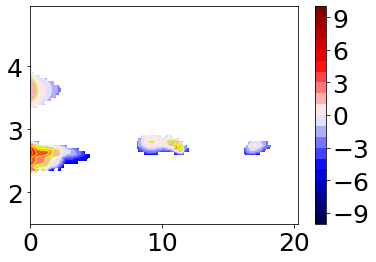

In [192]:
#color = pyart.graph.cm.LangRainbow12
#snow+graup
cmap=plt.cm.seismic
levels = MaxNLocator(nbins=20).tick_values(-10,10)
norm= BoundaryNorm(levels, ncolors=cmap.N, clip=False)

cmap1=plt.cm.jet
levels1 = MaxNLocator(nbins=20).tick_values(-10,10)
norm1= BoundaryNorm(levels1, ncolors=cmap1.N, clip=False)

B_pos=B.copy()
B_pos[np.where(B<0)]=np.nan
plt.contourf(xs,levs/1000,B,levels=levels, norm=norm, cmap = cmap)
plt.colorbar()
plt.contour(xs,levs/1000,B_pos,levels=levels1, norm=norm1, cmap = cmap1)

In [111]:
#Get inside and outside GC wa
wa_insideGC=wa_cross.copy()
wa_insideGC[:]=np.nan
wa_insideGC[np.where(dBZ_pert_final>1)]=wa_cross[np.where(dBZ_pert_final>1)]
wa_insideGC[np.where(height_cross>4500)]=np.nan
wa_insideGC[np.where(height_cross<3500)]=np.nan

wa_outsideGC=wa_cross.copy()
wa_outsideGC[~np.isnan(wa_insideGC)]=np.nan
wa_outsideGC[np.where(height_cross>4500)]=np.nan
wa_outsideGC[np.where(height_cross<3500)]=np.nan

outGC=wa_outsideGC[~np.isnan(wa_outsideGC.data)]
inGC=wa_insideGC[~np.isnan(wa_insideGC.data)]

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


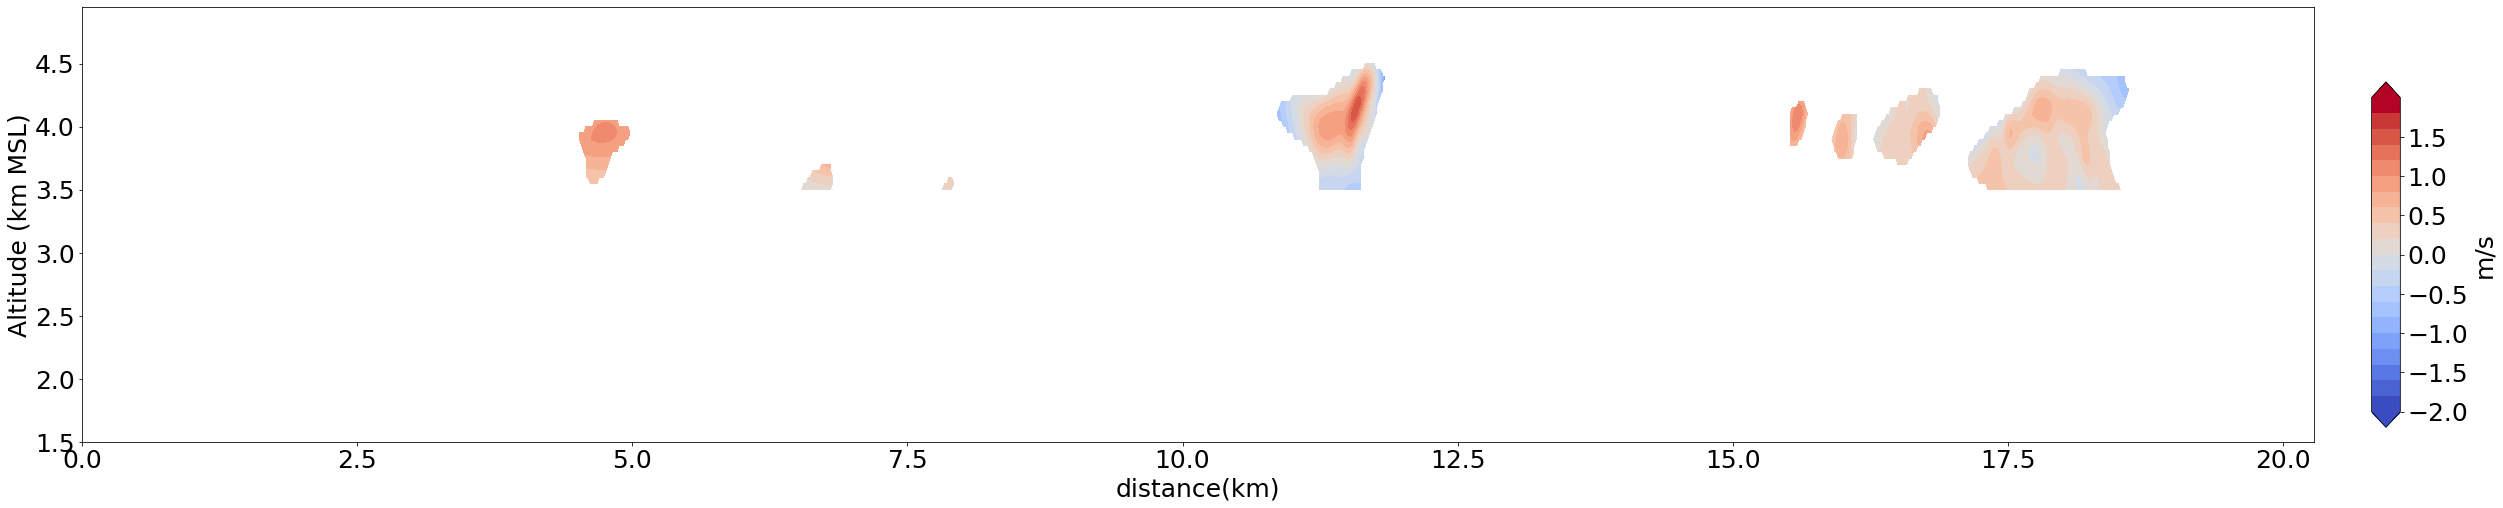

In [112]:
fig = plt.figure(figsize=(40,8))
ax_cross = plt.axes()

dbz_contour=ax_cross.contourf(xs,levs/1000,
                              wa_insideGC,
                            levels=levels_wa,
                            cmap=cmap_wa,
                            norm=norm_wa,
                            extend='both',zorder=0)
ax_cross.set_xlabel('distance(km)')
ax_cross.set_ylabel('Altitude (km MSL)')
cb = fig.add_axes([.92,.15,.01,.6])
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(dbz_contour,orientation='vertical', 
                    label='m/s',cax=cb, 
                    ticks=np.arange(-2,2,.5))

/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


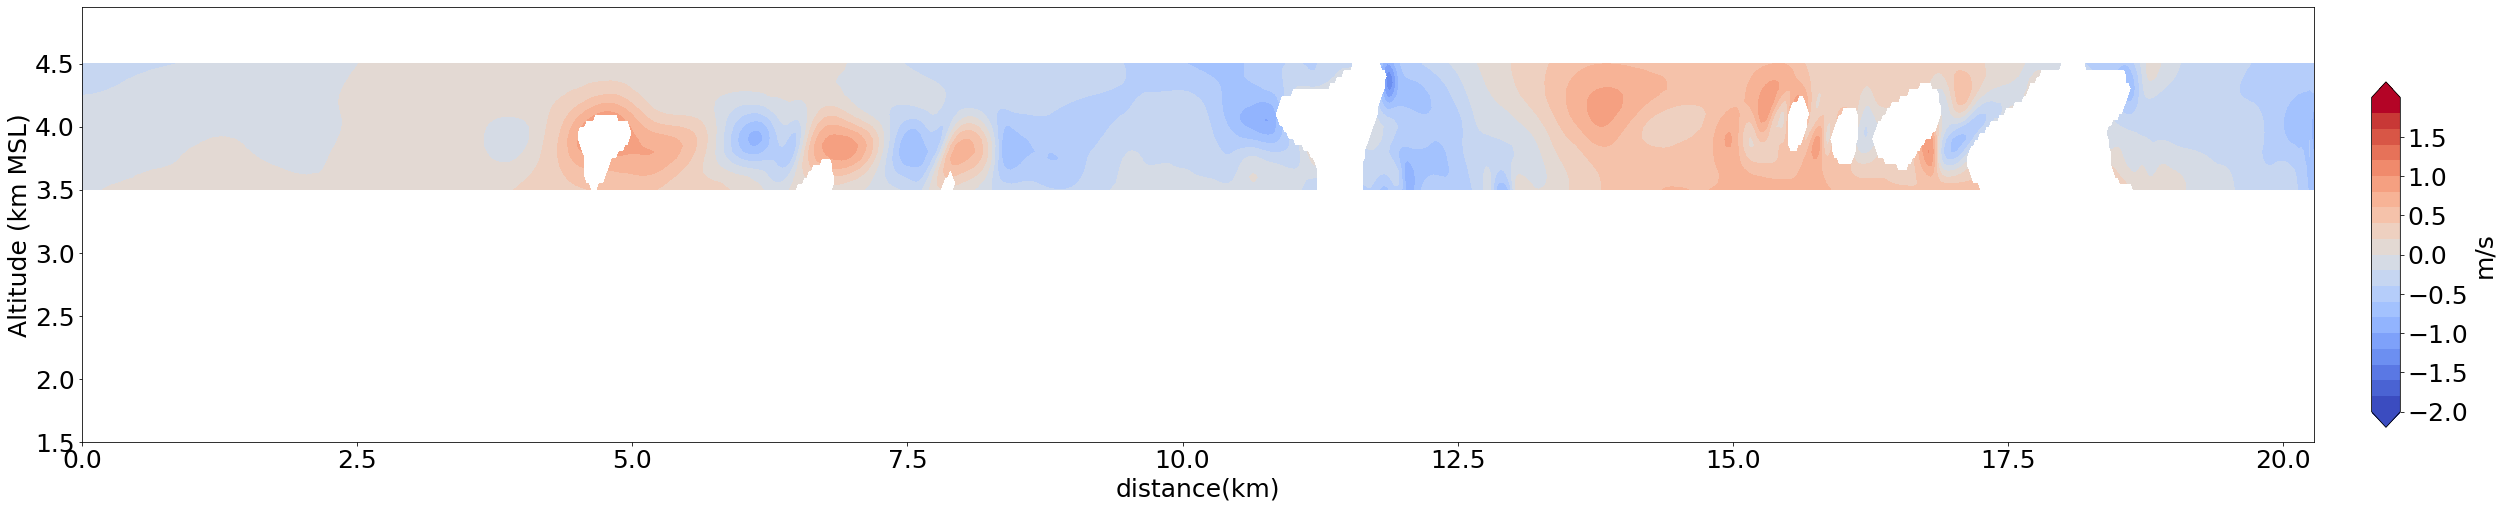

In [113]:
fig = plt.figure(figsize=(40,8))
ax_cross = plt.axes()

dbz_contour=ax_cross.contourf(xs,levs/1000,
                              wa_outsideGC,
                            levels=levels_wa,
                            cmap=cmap_wa,
                            norm=norm_wa,
                            extend='both',zorder=0)
ax_cross.set_xlabel('distance(km)')
ax_cross.set_ylabel('Altitude (km MSL)')
cb = fig.add_axes([.92,.15,.01,.6])
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(dbz_contour,orientation='vertical', 
                    label='m/s',cax=cb, 
                    ticks=np.arange(-2,2,.5))

-0.020574280992150307 0.28416985273361206


/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \ 
<>:4: DeprecationWarning: invalid escape sequence \ 
<ipython-input-114-a03f1256cbf2>:4: DeprecationWarning: invalid escape sequence \ 
  plt.ylabel('w $(m\ s^{-1})$');
/glade/u/home/sisichen/.conda/envs/geocat/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


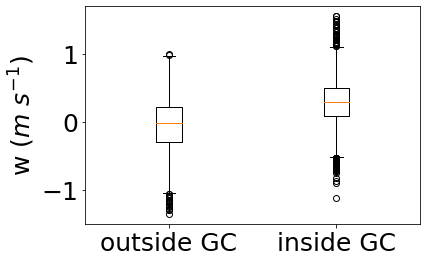

In [114]:
#box plot
names=['outside GC','inside GC'];
plt.boxplot([np.ndarray.flatten(outGC),np.ndarray.flatten(inGC)],labels=names);
plt.ylabel('w $(m\ s^{-1})$');
print(np.median(outGC),np.median(inGC))